In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, get_scheduler
from bitsandbytes.optim import Adam8bit,PagedAdam32bit
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
from peft import prepare_model_for_kbit_training
import torch
from IPython.display import  clear_output
import time
import gc
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

DEFAULT_MODEL = "meta-llama/Llama-3.2-3B-Instruct"

bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=False,
    )


model = AutoModelForCausalLM.from_pretrained(
    DEFAULT_MODEL,
    quantization_config=bnb_config,
    use_safetensors=True,
    device_map=device,
)

print(model.get_memory_footprint()/(1024*1024)) 

tokenizer = AutoTokenizer.from_pretrained(DEFAULT_MODEL, use_safetensors=True)
tokenizer.pad_token_id = tokenizer.eos_token_id

def flush():
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2095.841064453125


# Load a Multi Lingual Dataset

In [13]:
from datasets import load_dataset

# Load the dataset
# dataset = load_dataset("OdiaGenAI/hardcode_odia_qa_105")
dataset = load_dataset('OdiaGenAI/odia_domain_context_train_v1')

README.md:   0%|          | 0.00/2.63k [00:00<?, ?B/s]

odia_data_domain_full_train_v2.json:   0%|          | 0.00/9.78M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10502 [00:00<?, ? examples/s]

In [14]:
dataset['train'][0]

{'instruction': 'ଓଡ଼ିଶାର ଅର୍ଥନୀତି ଉପରେ ପର୍ଯ୍ୟଟନର କିଭଳି ପ୍ରଭାବ ପଡ଼ିଛି?',
 'input': '',
 'output': 'ବିଗତ କିଛି ବର୍ଷ ମଧ୍ୟରେ ପର୍ଯ୍ୟଟନ ଶିଳ୍ପ ଦ୍ୱାରା ଓଡ଼ିଶାର ଅର୍ଥନୀତି ବ୍ୟାପକ ଭାବେ ପ୍ରଭାବିତ ହୋଇଛି। ରାଜ୍ୟରେ ପ୍ରାକୃତିକ ସୌନ୍ଦର୍ଯ୍ୟ ଏବଂ ସାଂସ୍କୃତିକ ଐତିହ୍ୟ ସ୍ଥାନ ରହିଛି, ଯାହା ଦେଶ ଏବଂ ଦେଶ ବାହାରର ପର୍ଯ୍ୟଟକଙ୍କ ପାଇଁ ଆକର୍ଷଣୀୟ ହୋଇପାରିଛି।\nପର୍ଯ୍ୟଟନ କ୍ଷେତ୍ରରେ କାର୍ଯ୍ୟ କରୁଥିବା ଲୋକମାନଙ୍କ ପାଇଁ ନିଯୁକ୍ତି ସୁଯୋଗ ଏବଂ ଆୟ ବୃଦ୍ଧି ପାଇଛି, ଯେଉଁଥିରେ ଆତିଥ୍ୟ, ଟୁର ଅପରେଟର ଏବଂ ପରିବହନ ଶିଳ୍ପ ସାମିଲ ରହିଛି। ପର୍ଯ୍ୟଟନ ଶିଳ୍ପ ସ୍ଥାନୀୟ ଖାଦ୍ୟ, ହସ୍ତଶିଳ୍ପ ଏବଂ ସାଂସ୍କୃତିକ ଗତିବିଧିକୁ ପ୍ରୋତ୍ସାହିତ କରିବାରେ ସହାୟତା କରିଛି, ଯାହାକି ଓଡ଼ିଶାର ସାମଗ୍ରିକ ଅର୍ଥନୀତି ଉପରେ ସକାରାତ୍ମକ ପ୍ରଭାବ ପକାଇଛି।\nପର୍ଯ୍ୟଟକମାନଙ୍କ ପାଇଁ ଉତ୍ତମ ଅନୁଭୂତି ସୁନିଶ୍ଚିତ କରିବା ପାଇଁ ଭିତ୍ତିଭୂମି ବିକାଶ ଉପରେ ମଧ୍ୟ ସରକାର ଗୁରୁତ୍ୱ ଦେଉଛନ୍ତି। ସଡ଼କ ଏବଂ ସାର୍ବଜନୀନ ପରିବହନ ବ୍ୟବସ୍ଥାରେ ସୁଧାର କରାଯାଇଛି, ଯେତେବେଳେ କି ରାଜ୍ୟର ଅନେକ କ୍ଷେତ୍ରରେ ବିଭିନ୍ନ ଇକୋ-ଟୁରିଜମ ପ୍ରକଳ୍ପର ବିକାଶ କରାଯାଇଛି।\nଶେଷରେ ପର୍ଯ୍ୟଟନ ଓଡ଼ିଶାର ଆର୍ଥିକ ବିକାଶକୁ ତ୍ୱରାନ୍ୱିତ କରିବାରେ ଗୁରୁତ୍ୱପୂର୍ଣ୍ଣ ଭୂମିକା ନିର୍ବାହ କରିଛି ଏବଂ ରାଜ୍ୟବାସୀଙ୍କ ପାଇଁ ଅନେକ ଲାଭ ଆଣିପାରିଛି।'}

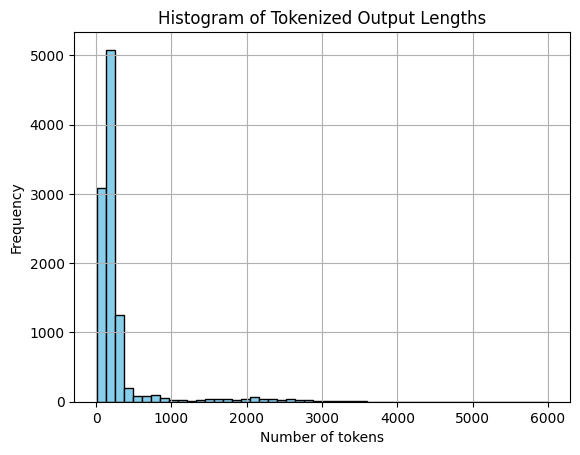

In [16]:
import matplotlib.pyplot as plt
lengths = [len(tokenizer(example['output'])['input_ids']) for example in dataset['train']]

# Plot the histogram
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Tokenized Output Lengths")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Create the Dataset Object for Pytorch-Dataset

In [4]:
# Custom PyTorch Dataset
class LlamaDataset(Dataset):
    def __init__(self, dataset):
        self.data = dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        question=sample['instruction']
        answer = sample['output']
        prompt = f'''<|begin_of_text|> <|start_header_id|>user<|end_header_id|>\n\n{question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'''
        full_text = prompt+f'''{answer}।<|eot_id|>'''

        tokenized = tokenizer(full_text, truncation=True, add_special_tokens=False, padding="max_length", max_length=380)

        input_ids = tokenized["input_ids"]
        attention_mask = tokenized["attention_mask"]

        # Tokenize just the prompt to get the split point
        prompt_ids = tokenizer(prompt, add_special_tokens=False)["input_ids"]
        answer_start = len(prompt_ids)

        # Mask everything before answer_start
        labels = [-100] * answer_start + input_ids[answer_start:]
        # Mask out padding as well
        labels = [
            label if token != tokenizer.pad_token_id else -100
            for label, token in zip(labels, input_ids)
        ]
    
        return {
        "input_ids": torch.tensor(input_ids),
        "attention_mask": torch.tensor(attention_mask),
        "labels": torch.tensor(labels)
    }
        

In [5]:
train_dataset = LlamaDataset(dataset['train'])
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [7]:
for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

model.embed_tokens.weight  dtype: torch.float16  requirs grad:  True
model.layers.0.self_attn.q_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.self_attn.k_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.self_attn.v_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.self_attn.o_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.mlp.gate_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.mlp.up_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.mlp.down_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.input_layernorm.weight  dtype: torch.float16  requirs grad:  True
model.layers.0.post_attention_layernorm.weight  dtype: torch.float16  requirs grad:  True
model.layers.1.self_attn.q_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.1.self_attn.k_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.1.self_attn.v_proj.weight  dt

# Purpose of `prepare_model_for_kbit_training`

When you load a model in 4-bit or 8-bit precision using bitsandbytes, some layers (like LayerNorm) still remain in full precision (float32), and certain operations (like weight updates) can be unstable or incompatible if done blindly on quantized weights.

- Casts `LayerNorm` layers to `float32`
- Sets `requires_grad=False` for all model parameters
- Wraps the output layer (like `lm_head`) in `float32`

In [8]:
model = prepare_model_for_kbit_training(model)

In [9]:
for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

model.embed_tokens.weight  dtype: torch.float32  requirs grad:  False
model.layers.0.self_attn.q_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.self_attn.k_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.self_attn.v_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.self_attn.o_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.mlp.gate_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.mlp.up_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.mlp.down_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.0.input_layernorm.weight  dtype: torch.float32  requirs grad:  False
model.layers.0.post_attention_layernorm.weight  dtype: torch.float32  requirs grad:  False
model.layers.1.self_attn.q_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.1.self_attn.k_proj.weight  dtype: torch.uint8  requirs grad:  False
model.layers.1.self_attn.v_proj.weight 

In [10]:
config = LoraConfig(
    r=64,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 97,255,424 || all params: 3,310,005,248 || trainable%: 2.9382


In [11]:
for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

base_model.model.model.embed_tokens.weight  dtype: torch.float32  requirs grad:  False
base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight  dtype: torch.uint8  requirs grad:  False
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight  dtype: torch.float32  requirs grad:  True
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight  dtype: torch.float32  requirs grad:  True
base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight  dtype: torch.uint8  requirs grad:  False
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight  dtype: torch.float32  requirs grad:  True
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight  dtype: torch.float32  requirs grad:  True
base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight  dtype: torch.uint8  requirs grad:  False
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight  dtype: torch.float32  requirs grad:  True
base_model.model

In [11]:
# question = '''ଓଡ଼ିଶାରେ ପର୍ଯ୍ୟଟନକୁ ପ୍ରୋତ୍ସାହନ ଦେବା ପାଇଁ ସରକାରୀ ଏବଂ ଘରୋଇ କ୍ଷେତ୍ର କିପରି ମିଳିମିଶି କାର୍ଯ୍ୟ କରିପାରିବେ?'''
# answer = '''ଯେକୌଣସି ରାଜ୍ୟରେ ପର୍ଯ୍ୟଟନକୁ ପ୍ରୋତ୍ସାହନ ଦେବା ପାଇଁ ସରକାରୀ ଏବଂ ଘରୋଇ କ୍ଷେତ୍ରର ମିଳିତ ପ୍ରୟାସର ଆବଶ୍ୟକତା ରହିଛି। ଓଡ଼ିଶାର ସରକାରୀ ଏବଂ ଘରୋଇ କ୍ଷେତ୍ର ରାଜ୍ୟରେ ପର୍ଯ୍ୟଟନକୁ ପ୍ରୋତ୍ସାହନ ଦେବା ଲାଗି ଏକ ବିସ୍ତୃତ ରଣନୀତି ବିକଶିତ ଏବଂ କାର୍ଯ୍ୟକାରୀ କରିବା ଲାଗି ମିଳିତ ଭାବେ କାର୍ଯ୍ୟ କରିପାରିବେ।
# ସରକାର ଘରୋଇ କ୍ଷେତ୍ର ସହିତ ମିଶି କାମ କରିବାର ଗୋଟିଏ ଉପାୟ ହେଲା ଘରୋଇ ନିବେଶ ପାଇଁ ଅନୁକୂଳ ବାତାବରଣ ସୃଷ୍ଟି କରିବା, ଏଥିରେ ଘରୋଇ କ୍ଷେତ୍ରର ଭାଗିଦାରୀକୁ ପ୍ରୋତ୍ସାହିତ କରିବା ପାଇଁ ଟିକସ ଏବଂ ନିୟାମକ ପ୍ରତିବନ୍ଧକକୁ ହ୍ରାସ କରିବା, ଏହା ବ୍ୟତୀତ ସରକାର ଟିକସ ରିହାତି, ସବସିଡି ଏବଂ ପର୍ଯ୍ୟଟନ ବିକାଶ ପ୍ରକଳ୍ପ ପାଇଁ ଜମି ଆଦି ପ୍ରୋତ୍ସାହନ ମଧ୍ୟ ପ୍ରଦାନ କରିପାରିବେ।
# ଘରୋଇ କ୍ଷେତ୍ର ସହ ମିଶି ସରକାର ଘରୋଇ କ୍ଷେତ୍ର ସହ ମିଶି ନୂତନ ପର୍ଯ୍ୟଟନ ଉତ୍ପାଦ ପ୍ରସ୍ତୁତ କରିପାରିବେ ଯାହା ଉଭୟ ଘରୋଇ ଏବଂ ଅନ୍ତର୍ଜାତୀୟ ପର୍ଯ୍ୟଟକଙ୍କ ଆବଶ୍ୟକତା ପୂରଣ କରିପାରିବ।
# ସରକାର ମଧ୍ୟ ଓଡ଼ିଶାରେ ପର୍ଯ୍ୟଟନକୁ ପ୍ରୋତ୍ସାହନ ଦେବା ଏବଂ ଘରୋଇ କ୍ଷେତ୍ରର ଭାଗିଦାରୀକୁ ପ୍ରୋତ୍ସାହିତ କରିବା ପାଇଁ ପ୍ରଯୁକ୍ତିର ଉପଯୋଗ କରିପାରିବେ। ଉଦାହରଣ ସ୍ୱରୂପ, ସରକାର ପର୍ଯ୍ୟଟନ ସ୍ଥଳକୁ ପ୍ରୋତ୍ସାହିତ କରିବା ଏବଂ ସମ୍ଭାବ୍ୟ ପର୍ଯ୍ୟଟକମାନଙ୍କ ସହିତ ଯୋଡ଼ିବା ଲାଗି ସୋସିଆଲ ମିଡିଆ ପ୍ଲାଟଫର୍ମର ଉପଯୋଗ କରିପାରିବେ। ଓଡ଼ିଶାରେ ପର୍ଯ୍ୟଟନ ଆକର୍ଷଣ ଏବଂ ଅନୁଭବ ପ୍ରଦର୍ଶିତ କରିବା ଲାଗି ଏକ ଅନଲାଇନ ପ୍ଲାଟଫର୍ମ ପ୍ରତିଷ୍ଠା କରିବା ଦ୍ୱାରା ଅଧିକ ପର୍ଯ୍ୟଟକଙ୍କୁ ଆକର୍ଷିତ କରିବାରେ ସହାୟତା ମିଳିପାରିବ।
# ପର୍ଯ୍ୟଟନକୁ ପ୍ରୋତ୍ସାହନ ଦେବା ଲାଗି ସରକାରୀ ଏବଂ ଘରୋଇ କ୍ଷେତ୍ରକୁ ମିଳିତ ଭାବେ କାର୍ଯ୍ୟ କରିବାକୁ ପଡିବ ଯେପରିକି ପର୍ଯ୍ୟଟନ ଗତିବିଧି ଦ୍ୱାରା ପର୍ଯ୍ୟାବରଣର କ୍ଷୟ କିମ୍ବା ସ୍ଥାନୀୟ ସମ୍ପ୍ରଦାୟର କ୍ଷତି ନ ହେଉ।
# ଶେଷରେ, ସରକାରୀ ଏବଂ ଘରୋଇ କ୍ଷେତ୍ରକୁ ଓଡ଼ିଶାରେ ପର୍ଯ୍ୟଟନକୁ ପ୍ରୋତ୍ସାହନ ଦେବା ଲାଗି ଏକ ଅନୁକୂଳ ପରିବେଶ ସୃଷ୍ଟି କରିବା ଆବଶ୍ୟକ ଏବଂ ଏହା ସୁନିଶ୍ଚିତ କରିବା ଉଚିତ ଯେ ବିକାଶ ସ୍ଥାୟୀ ହେବ। ” ମିଳିତ ଭାବେ କାର୍ଯ୍ୟ କରି ସେମାନେ ପର୍ଯ୍ୟଟନ ରଣନୀତିକୁ ବିକଶିତ ଏବଂ କାର୍ଯ୍ୟକାରୀ କରିପାରିବେ ଯାହା କେବଳ ପର୍ଯ୍ୟଟନ ଉଦ୍ୟୋଗ ନୁହେଁ ବରଂ ସ୍ଥାନୀୟ ଗୋଷ୍ଠୀ ଏବଂ ପରିବେଶକୁ ମଧ୍ୟ ଲାଭାନ୍ୱିତ କରିବ।'''

# tokenized_text = tokenizer(answer).input_ids
# print(len(tokenized_text))
# for idx in range(len(tokenized_text)):
#     clear_output(wait=True)
#     print(tokenizer.decode(tokenized_text[0:idx]))
#     time.sleep(0.1)

# Finetune the LLAMA model on a single text

In [10]:
for batch in train_dataloader:
    break

tokenizer.batch_decode(batch['input_ids'])

['<|begin_of_text|> <|start_header_id|>user<|end_header_id|>\n\nଆପଣଙ୍କ ବିଷୟରେ କୁହନ୍ତୁ।<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nମୁଁ ଅଲିଭ୍ ଏକ ଚାଟ୍ବଟ୍ ଆସିଷ୍ଟାଣ୍ଟ, ଯାହାକି ଓଡିଆ-ଜେନ-ଏ.ଆଇ. ଗବେଷକମାନଙ୍କ ଦ୍ୱାରା ପ୍ରଶିକ୍ଷିତ ଏକ ଭାଷା ମଡେଲ।।<|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|>',
 '<|begin_of_text|> <|start_header_id|>user<|end_header_id|>\n\

In [17]:
def generate_eval(model,idx=5,disable_lora=False):
    
    model.config.use_cache = True
    sample=dataset['train'][idx]
    question=sample['instruction']
    answer = sample['output']
    chat_template = f'''<|begin_of_text|> <|start_header_id|>user<|end_header_id|>\n\n{question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'''
    inputs = tokenizer(chat_template , return_tensors="pt").to(device)
    # print(prompt)

    model.eval()


    if disable_lora:
        with model.disable_adapter():
            output = model.generate(
                **inputs,
                do_sample=False,
                max_new_tokens=300,
                repetition_penalty=1.3,
                temperature=0.7,         # Optional: smooth randomness
                top_k=50,                # Optional: top-k sampling
                top_p=0.9                # Optional: nucleus sampling
            )
    else:
        output = model.generate(
        **inputs,
        do_sample=False,
        max_new_tokens=300,
        repetition_penalty=1.3,
        temperature=0.7,         # Optional: smooth randomness
        top_k=50,                # Optional: top-k sampling
        top_p=0.9                # Optional: nucleus sampling
        )

    processed_text = tokenizer.decode(output[0], skip_special_tokens=False)
    
    model.train()

    return processed_text

In [18]:
dataset['train'][40]

{'input': '',
 'english_input': '',
 'english_instruction': 'Tell me about you.',
 'instruction': 'ଆପଣଙ୍କ ବିଷୟରେ କୁହନ୍ତୁ।',
 'output': 'ମୁଁ ଅଲିଭ୍ ଏକ ଚାଟ୍ବଟ୍ ଆସିଷ୍ଟାଣ୍ଟ, ଯାହାକି ଓଡିଆ-ଜେନ-ଏ.ଆଇ. ଗବେଷକମାନଙ୍କ ଦ୍ୱାରା ପ୍ରଶିକ୍ଷିତ ଏକ ଭାଷା ମଡେଲ।',
 'english_output': 'I am Olive a chatbot assistant, a language model trained by researchers from OdiaGenAI.'}

In [19]:
pred = generate_eval(model=model,idx=40,disable_lora=True)
print(pred)

AttributeError: 'LlamaForCausalLM' object has no attribute 'disable_adapter'

In [58]:
model.config.use_cache = False
model.config.pretraining_tp = 1
gradient_accumulation_steps = 4
max_steps=500
# Define optimizer
optimizer = PagedAdam32bit(model.parameters(), lr=1e-4)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=max_steps,
)
# Training loop
model.train()

global_step= 0

while global_step< max_steps:
    for step,batch in enumerate(train_dataloader):
        model.config.use_cache = False
        model.train()
        
        # Forward pass
        outputs = model(input_ids=batch['input_ids'].to('cuda'), attention_mask=batch['attention_mask'].to('cuda'), labels=batch['labels'].to('cuda'))
        loss = outputs.loss
        loss = loss / gradient_accumulation_steps  # Normalize loss
        loss.backward()
        
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
        
        global_step += 1
        if global_step >= max_steps:
            break
        
        if global_step % 20 == 0:
            pred = generate_eval()
            print('*'*20,step+1,'*'*20)
            print("Predictions:", pred)
            print('*'*20,'end','*'*20)
            
        
        print(f"Epoch {global_step + 1}/{max_steps}, Loss: {loss.item():.4f}")
        
flush()

/home/mohan.dash/miniconda3/envs/diffusion_env/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch 2/500, Loss: 0.3461
Epoch 3/500, Loss: 0.3559
Epoch 4/500, Loss: 0.3663
Epoch 5/500, Loss: 0.3710
Epoch 6/500, Loss: 0.3310
Epoch 7/500, Loss: 0.3353
Epoch 8/500, Loss: 0.3283
Epoch 9/500, Loss: 0.3221
Epoch 10/500, Loss: 0.1307
Epoch 11/500, Loss: 0.1288
Epoch 12/500, Loss: 0.1364
Epoch 13/500, Loss: 0.1335
Epoch 14/500, Loss: 0.0817
Epoch 15/500, Loss: 0.0742
Epoch 16/500, Loss: 0.0786
Epoch 17/500, Loss: 0.0809
Epoch 18/500, Loss: 0.0820
Epoch 19/500, Loss: 0.0862
Epoch 20/500, Loss: 0.0569


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


******************** 6 ********************
Predictions: <|begin_of_text|><|begin_of_text|> <|start_header_id|>user<|end_header_id|>

ଆପଣଙ୍କ ନାଁ କ’ଣ?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Meta AI ଏବଂ ଚିତ୍ର-ସମୂହ, ଯଥା ଗବେଷ୍ଟ ଅଲିଭ ଓଡିଆ. Meta AI ଦ୍ୱ�
******************** end ********************
Epoch 21/500, Loss: 0.0567
Epoch 22/500, Loss: 0.0513
Epoch 23/500, Loss: 0.0590
Epoch 24/500, Loss: 0.0411
Epoch 25/500, Loss: 0.0355
Epoch 26/500, Loss: 0.0418
Epoch 27/500, Loss: 0.0441
Epoch 28/500, Loss: 0.0341
Epoch 29/500, Loss: 0.0193
Epoch 30/500, Loss: 0.0351
Epoch 31/500, Loss: 0.0294
Epoch 32/500, Loss: 0.0279
Epoch 33/500, Loss: 0.0334
Epoch 34/500, Loss: 0.0163
Epoch 35/500, Loss: 0.0217
Epoch 36/500, Loss: 0.0199
Epoch 37/500, Loss: 0.0197
Epoch 38/500, Loss: 0.0201
Epoch 39/500, Loss: 0.0171
Epoch 40/500, Loss: 0.0135


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


******************** 12 ********************
Predictions: <|begin_of_text|><|begin_of_text|> <|start_header_id|>user<|end_header_id|>

ଆପଣଙ୍କ ନାଁ କ’ଣ?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

ମୋ ଅଲିବ୍ ଏକ ଚାଟ୍ବତ୍ ଆସିଷ୍ଟାଣ୍ଟ, ଓଡିଆ-ଜେନ-�
******************** end ********************
Epoch 41/500, Loss: 0.0171
Epoch 42/500, Loss: 0.0116
Epoch 43/500, Loss: 0.0105
Epoch 44/500, Loss: 0.0117
Epoch 45/500, Loss: 0.0157
Epoch 46/500, Loss: 0.0143
Epoch 47/500, Loss: 0.0110
Epoch 48/500, Loss: 0.0069
Epoch 49/500, Loss: 0.0082
Epoch 50/500, Loss: 0.0067
Epoch 51/500, Loss: 0.0104
Epoch 52/500, Loss: 0.0055
Epoch 53/500, Loss: 0.0069
Epoch 54/500, Loss: 0.0069
Epoch 55/500, Loss: 0.0051
Epoch 56/500, Loss: 0.0040
Epoch 57/500, Loss: 0.0046
Epoch 58/500, Loss: 0.0054
Epoch 59/500, Loss: 0.0048
Epoch 60/500, Loss: 0.0045


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


******************** 4 ********************
Predictions: <|begin_of_text|><|begin_of_text|> <|start_header_id|>user<|end_header_id|>

ଆପଣଙ୍କ ନାଁ କ’ଣ?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

ମୋ ଅଲିଭ୍ ଏକ ବୁଦ୍ଧିଷ୍ଟ, ଓଂଶେନ ଚାଟ୍ବଟ୍ ଆସିଷ�
******************** end ********************
Epoch 61/500, Loss: 0.0042


KeyboardInterrupt: 

In [3]:
model.save_pretrained('/home/nas/buffer/mohan.dash/llama_3_finetuned/adapter')

In [ ]:
# Load the adapter into the base model
model_with_adapter = PeftModel.from_pretrained(model, 'adapter')
model_with_adapter.eval()

In [21]:
pred = generate_eval(model=model_with_adapter,idx=40,disable_lora=False)
print(pred)

/home/mohan.dash/miniconda3/envs/diffusion_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/mohan.dash/miniconda3/envs/diffusion_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|><|begin_of_text|> <|start_header_id|>user<|end_header_id|>

ଆପଣଙ୍କ ବିଷୟରେ କୁହନ୍ତୁ।<|eot_id|><|start_header_id|>assistant<|end_header_id|>

ମୋ ଅଲିଭ୍ ଏକ ଚାଟ୍ବଟ୍ ଆସିଷ୍ଟାଣ୍ଟ, ଯାହାକି ଓଡିଆ-ଜେନ-ଏ.ଆଇ. ଗବେଷକମାନଙ୍କ ଦ୍ୱାରା ପ୍ରଶିକ୍ଷିତ ଏକ ଭାଷା ମଡେଲ ।।।।।।।।। ଉଁକି ଅଲିଭ୍ ଏକ ଭାଷା ମଡ�


In [16]:
save_path = "/home/nas/buffer/mohan.dash/llama_3_finetuned/model_checkpoint.pt"

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'global_step': global_step
}, save_path)

print(f"Checkpoint saved to {save_path}")

Checkpoint saved to /home/nas/buffer/mohan.dash/llama_3_finetuned/model_checkpoint.pt
